In [1]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *

from scipy.optimize import minimize_scalar
from scipy.stats import linregress

# The helper file below brings functions created in previous tutorials and adds an extra one
# make_df_for_energy_scan - we made this in tutorial 4
# make_braket_labels - we made this in tutorial 4
# simulate - we made this in tutorial 4
# plot_prob - made from code used for plotting in tutorial 4
# prettify_states - nice way to display many QuTiP states for side by side comparison
# 
from libs.helper_05_tutorial import *

# Excitation transfer in more detail

## Matched TSS

Excitation transfer is not an effect that we readily observe in quantum systems. To appreciate why, it is instructive to look at how the excitation transfer time corresponding to the Rabi cycle we observed in the last tutorial depends of the different parameters in our Hamiltonian.

$$H =  \frac{\Delta E}{2} (\sigma_{z1} + \sigma_{z2}) + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)(\sigma_{x1} + \sigma_{x2})$$



In [2]:
H_latex = "$H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$ "

Let's keep the boson energy constant and set $\omega = 1$ as we've done in previous tutorials.

In [3]:
omega = 1

We'll increase the coupling from last time to $U = 0.1$ to make our explorations easier from a computational perspective.

In [4]:
U = 0.1

And we'll focus on even parity

In [5]:
parity = 1

We'd like to see how the excitation transfer time depends on the TSS transition energy $\Delta E$. In general though, it's not possible to simply vary $\Delta E$ continuously across large range and look at how long it takes for $|1,+, - \rangle$ to transform into $|1,-, + \rangle$. The reason is that `excitation transfer` cannot be totally separated from  what we might call `energy exchange`. 

Energy exchange occurs when $\Delta E = n\omega$. That's when spontaneous emission and down convertsion can occur. Close to those "resonances", energy exchange dominates over excitation transfer.

We can however, artificially suppress the energy exchange resonances by limiting the number of bosons in the system to 2. We can motivate that this is a good approximation by referring to the Hinton diagram (Fig 3) from the [last tutorial](https://nbviewer.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb).

$|1,+, - \rangle $ is coupled to 4 other states (i.e. they have non-zero matrix elements):
- $|0,+, + \rangle $
- $|0,-, - \rangle $
- $|2,+, + \rangle $
- $|2,-, - \rangle $


and those states are then coupled to the final state $|1,-, + \rangle $. In that sense, we say $|1,+, - \rangle $ is indirectly coupled to $|1,-, + \rangle $.

> It is interesting to observe that the excitation transfer between $|1,+, - \rangle $ and $|1,+, - \rangle $ involves states that appear to violate our usual sense of conservation of energy. For example, the state $|2,+, + \rangle $ has an extra boson and an extra excitation in the TSS compared to $|1,+, - \rangle $.

We can therefore expect that the most important states contributing to the excitation transfer process can be captured by setting `max_bosons=2` (so long as the coupling is weak).

In [263]:
max_bosons = 2

In [264]:
def make_operators(max_bosons, parity=0):
    a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
    sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
    sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator 
    
    J     = jspin(2, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                               # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                               # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])  # tensorised J^2 operator
    
    two_state_1     =  1/2*sz1                                  # two state system energy operator   𝜎𝑧1/2
    two_state_2     =  1/2*sz2                                  # two state system energy operator   𝜎𝑧2/2
    bosons          = (a.dag()*a+0.5)                           # boson energy operator              𝑎†𝑎+1/2
    number          = a.dag()*a                                 # boson number operator              𝑎†𝑎
    interaction_1   = (a.dag() + a) * sx1                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a.dag() + a) * sx2                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2  
    
    P = sz1*sz2*(1j*np.pi*number).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
    
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        P               = P.extract_states(p)
        J2              = J2.extract_states(p)
        nmm_list        = [nmm_list[i] for i in p]

    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list



In [265]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)

In [233]:
# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E$", 0, 200, 2001, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

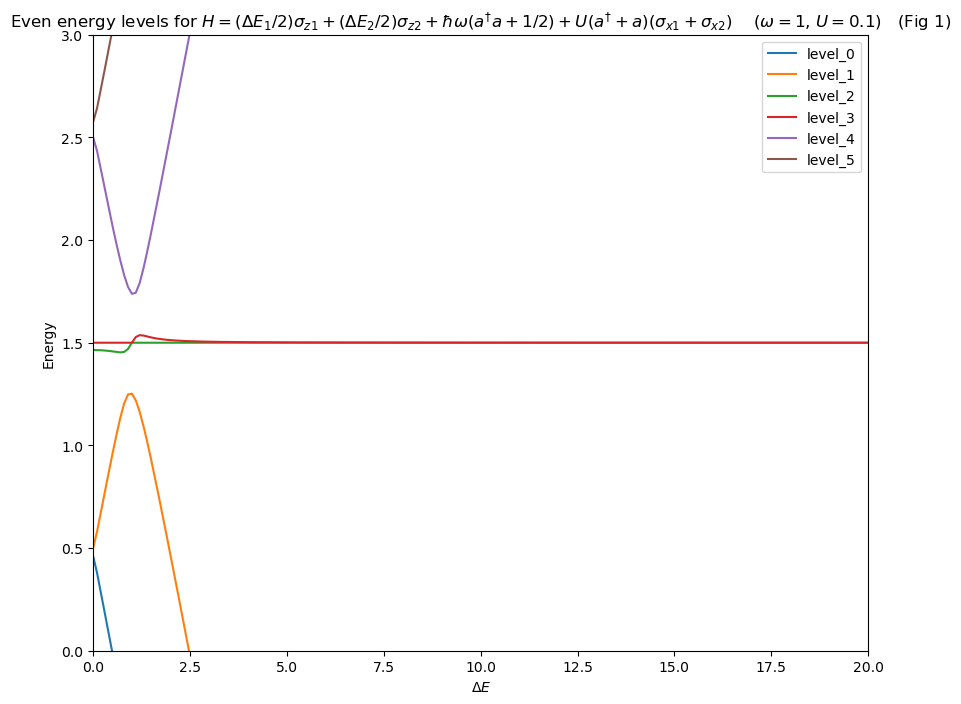

In [235]:
df_even.plot(x="$\Delta E$",ylim=[0,3],xlim=[0,20], legend=True, 
        title=f"Even energy levels for {H_latex}   ($\omega={omega}$, $U={U}$)   (Fig 1)",
             figsize=(10,8));

plt.ylabel("Energy");


Fig 1 shows us the 4 levels coming together at $\Delta E = 1$ - we explored this energy exchange last time. Non-radiative excitation transfer does not occur around $\Delta E = 1$ because of the energy exchange resonance that occurs there (i.e. TSS energy can be exchanged for boson energy because they are the same).

> You might be wondering why we don't have the same 4 level crossing at $\Delta E = 3, 5, 7$ and so on. In reality we do, but we have suppressed that physics by setting max_bosons = 2

Away from $\Delta E = 1$, excitation transfer can be understood as as result of frequency beating between levels 2 and 3 as we showed last time. To calculate the excitation transfer time, we therefore need to do: 

$$T = \frac{2 \pi}{E_\text{level 3} - E_\text{level 2} }$$

for all the different $\Delta E$.

In [246]:
df_even23 = df_even[["$\Delta E$", "level_2", "level_3"]] # Only keep levels 2 and 3

In [247]:
# Discard DeltaE < 2.5 so that we don't include effects from the energy resonance at DeltaE=1
df_even23 = df_even23[df_even23["$\Delta E$"]>=2.5] 

In [248]:
df_even23["Time"] = 2*np.pi / (df_even23["level_3"] - df_even23["level_2"])  # Calculate the excitation transfer time

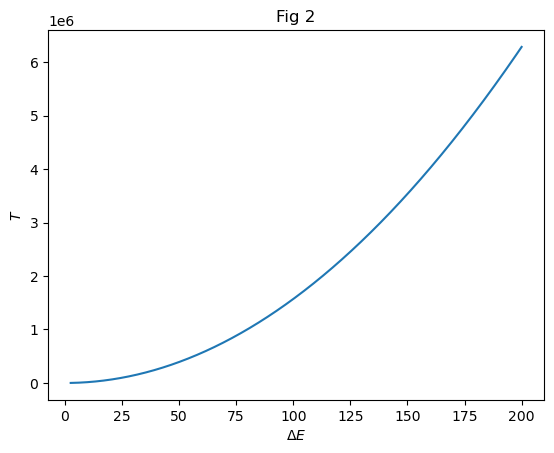

In [249]:
df_even23.plot(x="$\Delta E$",y="Time", title="Fig 2", legend=False);
plt.ylabel("$T$");

The plot looks quadratic in nature. We can try viewing it in as a log-log plot.

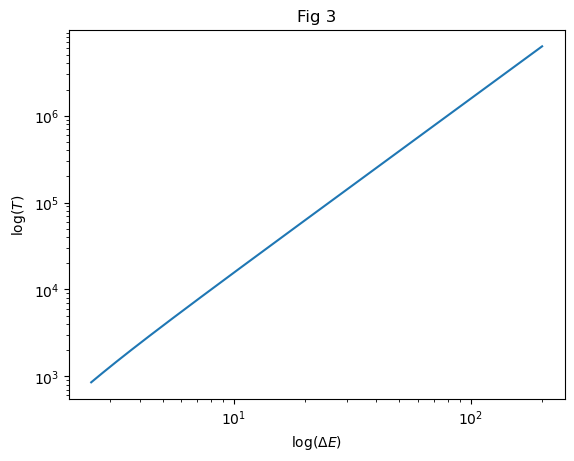

In [205]:
df_even23.plot(x="$\Delta E$",y="Time",logx = True, logy = True, title="Fig 3", legend=False);
plt.xlabel("$\log(\Delta E)$")
plt.ylabel("$\log(T)$");

Let's look at the gradient of this line to interpret Fig 3

In [206]:
linregress(np.log10(df_even23["$\Delta E$"]), np.log10(df_even23["Time"])).slope

2.0060139454941455

The gradient of 2 tells us that we've do indeed have a quadratic relationship between TSS transition energy and excitation transfer time. In other words, if we increase the TSS transition energy by a factor of 10 compared to the boson energy $\omega$, then the excitation transfer time goes up by a factor of 100.

It's worth remembering that we've suppressed all the energy exchange resonances to extract this scaling. Close to $\Delta E = n \omega$ this scaling therefore won't make sense. Nevertheless the scaling is still helpful for us to get a sense of how weak the excitation transfer becomes as $\Delta E$ increases.

## Mismatched TSS

So far, we looked at the case where the TSS have the same transition energy, we say they are matched. What about the case when there is a mismatch in the energies? In other words:

$$H =  \frac{\Delta E_1}{2} \sigma_{z1} + \frac{\Delta E_2}{2}\sigma_{z2} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)(\sigma_{x1} + \sigma_{x2})$$


In [266]:
H_latex = "$H = (\Delta E_1 /2) \sigma_{z1} + (\Delta E_2 /2) \sigma_{z2} + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$ "

We'll fix $\Delta E_2 = 2.5$ and scan through $\Delta E_1$ to look at the energy level landscape

In [267]:
DeltaE2 = 2.5

In [268]:
# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E_1$", 0, 200, 2001, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E_1$"]*two_state_1+ DeltaE2*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

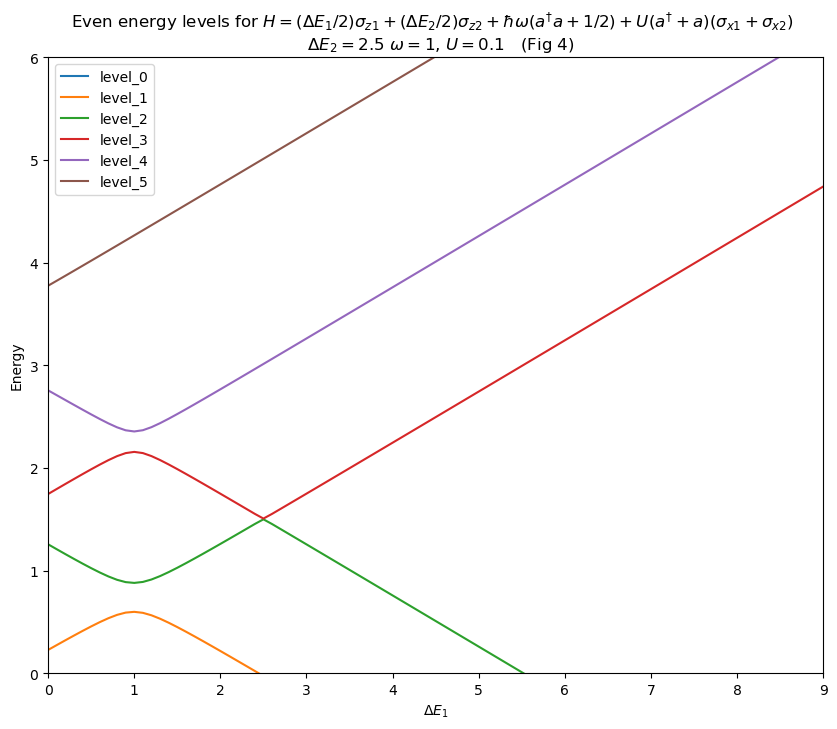

In [269]:
df_even.plot(x="$\Delta E_1$",ylim=[0,6],xlim=[0,9], legend=True, 
        title=f"Even energy levels for {H_latex} \n  $\Delta E_2={DeltaE2}$ $\omega={omega}$, $U={U}$   (Fig 4)",
             figsize=(10,8));

plt.ylabel("Energy");


Fig 4 shows us energy exchange resonances at $\Delta E_1 = 1$. This is when the boson energy matches TSS_1 and we get exhange of energy between the TSS and the boson field. In that case, TSS_2 is not involved in the dynamics at all because it's transition energy is not matching either the boson energy of the transition energy of TSS_1.

When $\Delta E_1 = 2.5$, we have matched transition energies between TSS_1 and TSS_2. As we've already explored, we know that excitation transfer occurs here. What's new from this plot is that we can see the visual signature that we've come to expect when interesting physics happens, namely an anti-crossing. Let's check this because on this scale we can't see it. 

We'll create a function to calculate the level differences just like we did last time. But this time, we'll make the function more general so make all parameters independent.

In [270]:
def level_difference(DeltaE, DeltaE2, omega, U1, U2, level_number):
    H = DeltaE*two_state_1 + DeltaE2*two_state_2 + omega*bosons + U1*interaction_1 + U2*interaction_2
    evals, ekets = H.eigenstates()
    return np.abs(evals[level_number] - evals[level_number-1])

We'll also make a function to help us create sensible ranges for our anti-crossing plots. This function aims to put the anti-crossing in the middle of the plot.

In [271]:
def plot_anti_crossing(DeltaE1, DeltaE2, omega, U, level, anti_crossing, splitting):
    df = make_df_for_energy_scan("$\Delta E_1$", DeltaE1-2*splitting, DeltaE1+2*splitting, 201, two_state_1.shape[0])

    for i, row in df.iterrows():
        H =  row["$\Delta E_1$"]*two_state_1+ DeltaE2*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
        evals, ekets = H.eigenstates()
        df.iloc[i,1:] = evals
        
    ax = df.plot(x="$\Delta E_1$",figsize=(10,8),ylim=[anti_crossing-2*splitting, anti_crossing+2*splitting], 
        title=f"Even energy levels for {H_latex} \n  $\Delta E_2={DeltaE2}$ $\omega={omega}$, $U={U}$");
    ax.set_ylabel("Energy");
    return ax



Let's once again employ minimize_scalar to find the precise anti-crossing point. We do this because the resonance dynamics can in general be very sensitive.


Maximum number of iterations exceeded
 message: 
          Maximum number of iterations exceeded
 success: False
     fun: 0.007386154431794356
       x: 2.50002575480924
     nit: 400
    nfev: 405


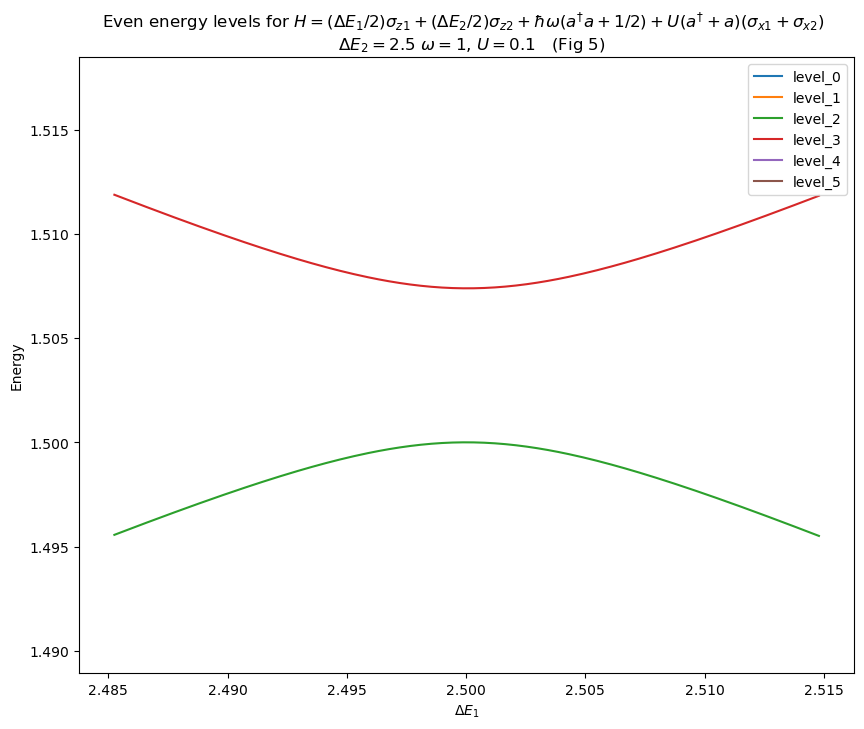

In [273]:
DeltaE1 = 2.5 # This is our starting guess for the DeltaE1 
DeltaE2 = 2.5
level = 3

# We are using method Golden with low tolerance in order to have best chance of detecting small anticrossings
anti_crossing = minimize_scalar(level_difference, args=(DeltaE2, omega, U, U, level), options={"maxiter":400,"disp":True}, tol=1e-20, method="Golden", bracket=[DeltaE1-0.25, DeltaE1+0.25])
print(anti_crossing)
H = anti_crossing.x*two_state_1 + DeltaE2*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
evals, ekets = H.eigenstates()
splitting = evals[level] - evals[level-1]
anti_crossing_energy = (evals[level] + evals[level-1])/2
ax = plot_anti_crossing(anti_crossing.x, DeltaE2, omega, U, level, anti_crossing_energy, anti_crossing.fun)
ax.set_title(f"{ax.get_title()}   (Fig 5)");

Fig 5 shows us how excitation transfer can be thought of as a kind of resonance just like energy exchange resonances that we've explored before.

We can see more physics if we increase `max_bosons` from 2 to 4.

In [307]:
max_bosons = 4
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)

In [308]:
# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E_1$", 0, 200, 2001, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E_1$"]*two_state_1+ DeltaE2*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

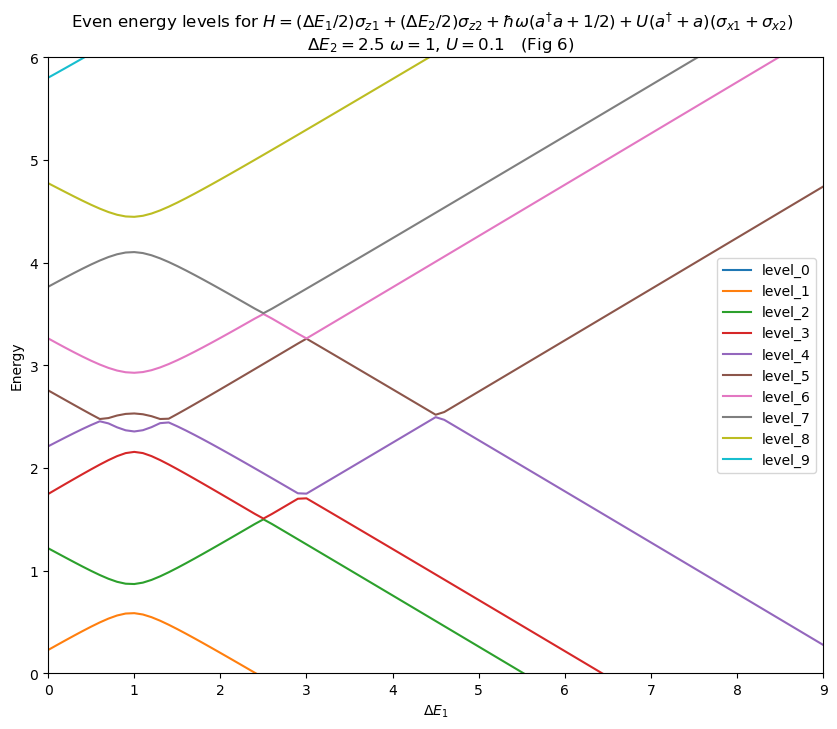

In [315]:
df_even.plot(x="$\Delta E_1$",ylim=[0,6],xlim=[0,9], legend=True, 
        title=f"Even energy levels for {H_latex} \n  $\Delta E_2={DeltaE2}$ $\omega={omega}$, $U={U}$   (Fig 6)",
             figsize=(10,8));

plt.ylabel("Energy");


Several new things to talk about here.

At $\Delta E_1 = 3$ we've got an anti-crossing associated with down conversion between levels 3 and 4. This is where TSS_1 transitions and the energy is converted into 3 bosons. We explored this in [Tutorial 04](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb).

At $\Delta E_1 = 4.5$, we've got another anti-crossing between levels 4 and 5. What's going on here? Let's first get a zoomed in view to check that it's a genuine anti-crossing.


Maximum number of iterations exceeded
 message: 
          Maximum number of iterations exceeded
 success: False
     fun: 5.4162078174435635e-05
       x: 4.5237004727858885
     nit: 400
    nfev: 405


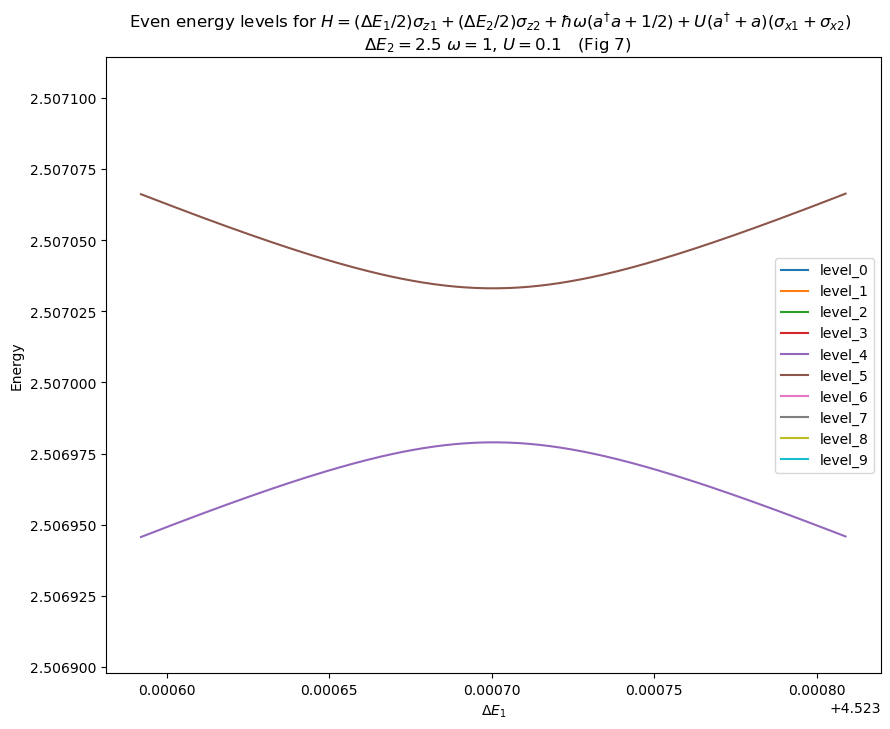

In [310]:
DeltaE1 = 4.5 # This is our starting guess for the DeltaE1 
DeltaE2 = 2.5
level = 5

# We are using  Golden method with low tolerance in order to have best chance of detecting small anticrossings
anti_crossing = minimize_scalar(level_difference, args=(DeltaE2, omega, U, U, level), options={"maxiter":400,"disp":True}, tol=1e-20, method="Golden", bracket=[DeltaE1-0.25, DeltaE1+0.25])
print(anti_crossing)
H = anti_crossing.x*two_state_1 + DeltaE2*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
evals, ekets = H.eigenstates()
splitting = evals[level] - evals[level-1]
anti_crossing_energy = (evals[level] + evals[level-1])/2
ax = plot_anti_crossing(anti_crossing.x, DeltaE2, omega, U, level, anti_crossing_energy, anti_crossing.fun)
ax.set_title(f"{ax.get_title()}   (Fig 7)");

We've got a genuine anti-crossing. We have come to expect rabi like oscillations on a timescale associated with the difference between the levels, i.e.

In [311]:
rabi_time = 2*np.pi/anti_crossing.fun

Let's run a simulation for 3 times this `rabi_time` and see what we get if we start things off in the $|1,+, + \rangle$ state just like we did in the last tutorial.

A reminder, $|1,+, - \rangle$ corresponds to state number 2 in QuTip's way of enumerating the states.

In [312]:
nmm_list[2]

(1, '+', '-')

In [313]:
psi0 = basis(len(nmm_list), 2)
times = np.linspace(0.0, rabi_time*3, 10000)
P, psi = simulate(H, psi0, times)

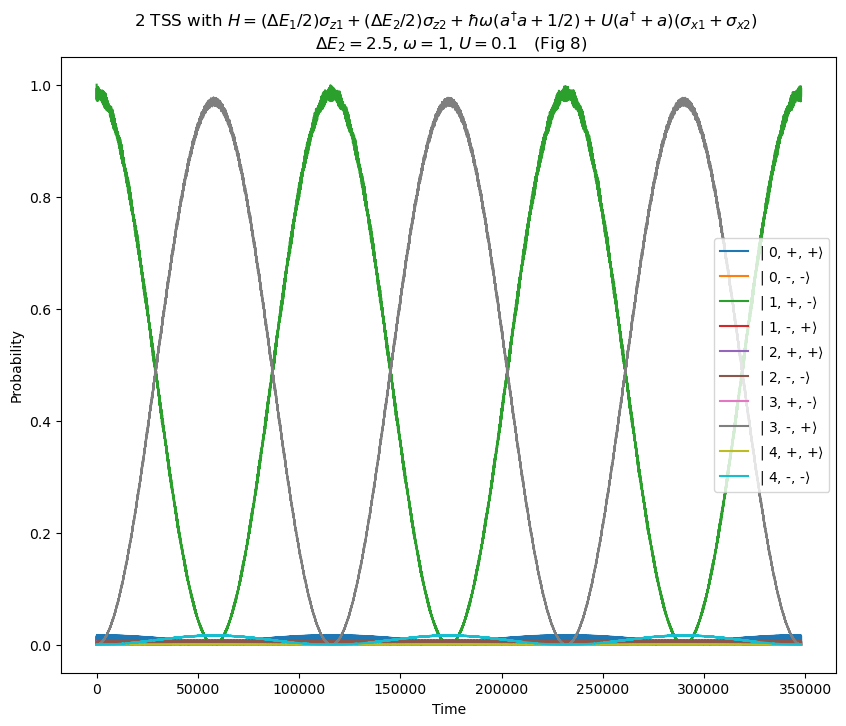

In [314]:
bra_labels, ket_labels = make_braket_labels(nmm_list)
plot_prob(P ,times, ket_labels)
plt.title(f"2 TSS with {H_latex} \n $\Delta E_2 = {DeltaE2}$, $\omega={omega}$, $U={U}$   (Fig 8)");

Fig 8 shows us a kind of hybrid between radiative and non-radiative excitation transfer. Although the TSS transition energies are not matched ($\Delta E_1 - \Delta E_2 = 2$), the excitation can move from TSS_1 to TSS_2 by emitting a number of bosons to make up the energy difference. In this case, 2 bosons are emitted which allows us to Rabi osscilate between $|1,+, - \rangle $ and $|3,-, + \rangle $. 

> Side note, this resonance is very sensitive, try re-running the simulation with `H = 4.5*two_state_1 + 2.5*two_state_2 + 1*bosons + 0.01*interaction_1 + 0.01*interaction_2` and you'll find no excitation transfer at all


You might be wondering why we did not see this kind of behaviour when $\Delta E_1 - \Delta E_2 = 1$. In other words, why did 2 bosons have to be emitted? This is because of parity conservation. When we have energy exchange resonances, an odd number of bosons must be emitted, but for excitation transfer if must be an even number.

We should therefore expect to find other excitation transfer resonance when $\Delta E_1 - \Delta E_2 = 4, 6, 8$ etc. We'll need to keep increasing the number of bosons in order to explore these.

Let's try and automate the process of extracting the excitation transfer time when the mismatch in the transition energies of the TSS's is $0\omega, 2\omega, 4\omega, 6\omega, 8 \omega$.

For this, we'll need to create a function to find the 2 levels associated with the anti-crossing.

In [382]:
def find_crossing_level(DeltaE1, DeltaE2, omega, U1, U2, tol):
    H = DeltaE1*two_state_1 + DeltaE2*two_state_2 + omega*bosons + U1*interaction_1 + U2*interaction_2
    evals, ekets = H.eigenstates()
    return np.argmax(np.diff(evals) < tol) + 1 # finds the first pair of levels that are closer together than "tol" apart

We'll need to increase the size of the simulation space as we increase the mismatch in order to capture all the states that contribute to the excitation transfer. Specifically, we'll need 2 more bosons than the number of bosons emitted during the mismatched excitation transfer.

In [383]:
bosons_emitted = [0,2,4,6,8]
DeltaE2 = 2.5

transfer_times = [] # Empty list to hold the excitation transfer times


for i, bos in enumerate(bosons_emitted):
    max_bosons = bos+2 # Final state is |1+bos,-,+>, we need to include one more boson above this state to capture all the non-zero matrix elements in the hamiltonian 
    two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)
    DeltaE1 = DeltaE2 + bos # set the mismatch to be even number of bosons
    level = find_crossing_level(DeltaE1, DeltaE2,omega, U, U, 0.1)
    # We are using method Golden with low tolerance in order to have best chance of detecting small anti-crossings
    anti_crossing = minimize_scalar(level_difference, args=(DeltaE2, omega, U, U, level), options={"maxiter":400}, tol=1e-20, method="Golden", bracket=[DeltaE1-0.25, DeltaE1+0.25])
    transfer_times.append(2*np.pi/anti_crossing.fun)

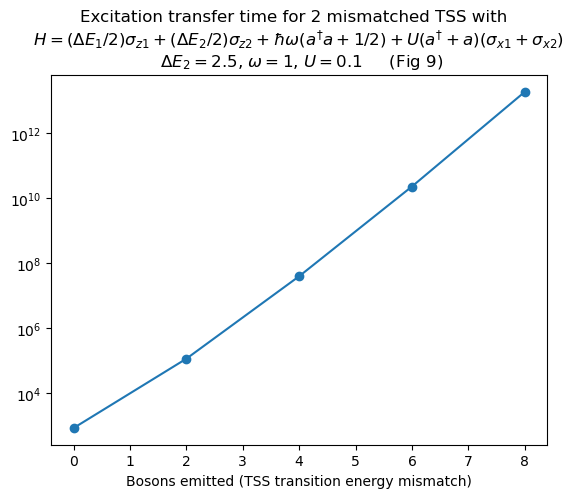

In [384]:
transfer_times_df = pd.DataFrame(data={"bosons":bosons_emitted, "times":transfer_times})
ax = transfer_times_df.plot(x="bosons",y="times", logy = True, title=f"Excitation transfer time for 2 mismatched TSS with  \n {H_latex} \n $\Delta E_2=2.5$, $\omega=1$, $U=0.1$     (Fig 9)", legend=False, style='o-');
ax.set_xlabel("Bosons emitted (TSS transition energy mismatch)");

In [319]:
linregress(transfer_times_df["bosons"], np.log10(transfer_times_df["times"])).slope

1.3001654307591886

The straight (ish) line in Fig 12 tells us we've got an exponential relationship between the number of bosons emitted and the excitation transfer time between two mismatched TSS. The gradient of 1.3 tells us that for every additional boson that's emitted, the excitation transfer time increases by a factor of $10^{1.3} \approx 20$.

The fact that the line is not completely straight may be due to the increased excitation of the field, i.e. the greater number of bosons. We already saw in the energy level diagrams of [Tutorial 04](https://nbviewer.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb) how splittings at various anti-crossings depended on boson number. We'll return to look at the effect of excitation level of the bosons at a later point.

## Bringing it all together

Let's combine the mismatch in energy with changing $\Delta E$.

We'll change $\Delta E_2$ by 2 orders of magnitude and look at a mismatch of TSS transition energy of 0, 2 and 4 bosons worth of energy.

In [387]:
DeltaE2s = [2.5, 20.5, 200.5]

data = {"bosons":[0,2,4, 6]}

for j, DeltaE2 in enumerate(DeltaE2s):

    transfer_times = [] # Empty list to hold the excitation transfer times

    for i, bos in enumerate(data["bosons"]):
        max_bosons = bos+2 # Final state is |1+bos,-,+>, we need to include one more boson above this state to capture all the non-zero matrix elements in the hamiltonian 
        two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)
        DeltaE1 = DeltaE2 + bos # set the mismatch to be even number of bosons
        level = find_crossing_level(DeltaE1, DeltaE2, omega, U, U, 0.1)
        # We are using method Golden with low tolerance in order to have best chance of detecting small anti-crossings
        anti_crossing = minimize_scalar(level_difference, args=(DeltaE2, omega, U, U, level), options={"maxiter":400}, tol=1e-20, method="Golden", bracket=[DeltaE1-0.25, DeltaE1+0.25])
        transfer_times.append(2*np.pi/anti_crossing.fun)

    data[DeltaE2] = transfer_times

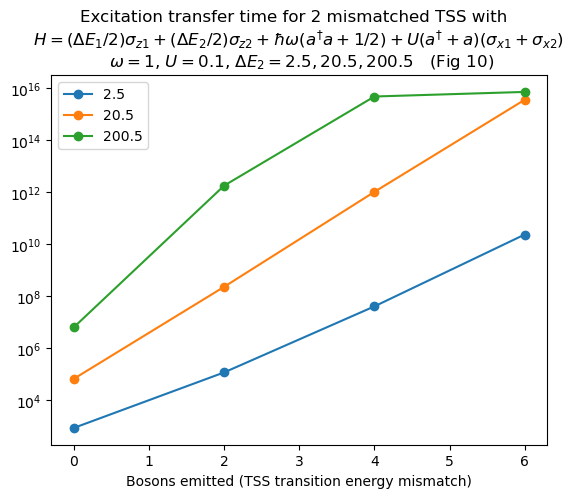

In [388]:
transfer_times_df = pd.DataFrame(data=data)
ax = transfer_times_df.plot(x="bosons", logy = True, title=f"Excitation transfer time for 2 mismatched TSS with  \n {H_latex} \n $\omega=1$, $U=0.1$, $\Delta E_2=2.5, 20.5, 200.5$   (Fig 10)", legend=True, style='o-');
ax.set_xlabel("Bosons emitted (TSS transition energy mismatch)");

Let's start with looking at "0 bosons emitted" in Fig 10 - this is the case we studied at the start of the notebook i.e. no mismatch in energy. The data points are equally spaced vertically which is consistent with the quadratic dependency of the excitation transfer time on transition energy that we found in Fig 3.

Moving our attention to "2 bosons emitted" - this is the case when $\Delta E_2 - \Delta E_1 = 2\omega$. We can start to see an uneven spacing of the data points. This uneven spacing suggests a scaling of excitation transfer time with transition energy that is greater than polynomial when we have mismatched TSS.

Finally, we can see what appears to be deviation of the straight line tendency for $\Delta E_2 = 200.5$. This is due to the limitations of QuTips eigenvalue solver. It's not possible to resolve excitation transfer times longer than about $10^{16}$. So, "4 bosons emitted" and "6 bosons emitted" appear smaller than they would otherwise be.